## Autoregressive Models

Autoregressive coeffcients are solved as $\mathbf{X}w=y$, where $\mathbf{X}$ is a $n \times p$ Hankel matrix of lagged time series values, $w$ is the vector of autoregressive coefficients, and $y$ is a vector of future values along the signal. 

$$
\mathbf{X} =
    \left[ {\begin{array}{ccccc}
    x_{0} & x_{1} & x_{2} & \cdots & x_{p}\\
    x_{1} & x_{2} & x_{3} & \cdots & x_{p+1}\\
    x_{2} & x_{3} & x_{4} & \cdots & x_{p+2}\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    x_{n-p-1} & x_{n-p} & x_{n-p+1} & \cdots & x_{n-1}\\
    \end{array} } \right] \\
\mathbf{y}^{\top} = 
    \left[ {\begin{array}{c}
    x_{p+1} \\
    x_{p+2} \\
    x_{p+3} \\ 
    \cdots \\
    x_{n} \\ 
    \end{array} } \right] \\
$$

## SVD

SVD can be used to solve AR weights, $w$, using the pseudo inverse (e.g. inverse of singular values).

$$
\begin{align*}
\mathbf{X}w &= y \\
w &= \mathbf{X}^{-1}y \\
\end{align*}
$$

SVD gives:

$$
\begin{align*}
\mathbf{X} &= USV^{\top} \\
\mathbf{X}^{-1} &= VS^{-1}U^{\top}\\
w &= VS^{-1}U^{\top}y
\end{align*}
$$

This is used for solving any AR(p) processes. But timescales are often captured by AR(1), even in the presence of other structure e.g. oscillations.

## Timescales and AR(1) 

Timescales refer to the decay rate of the autocorrelation function or the half width half max of power spectral density. Timescales may be directly quantified from the single AR(1) coefficient. Even in the presents of other temporal structure, the bias of an AR(1) approximation of the timescales slightly increases, while the computation time drastically decreases. 

$$
\begin{align*}
x^{\top} w &= y \\
\left[ {\begin{array}{ccccc}
x_{0} \\
x_{1} \\
x_{2} \\
\vdots \\
x_{n-1} \\
\end{array} } \right] w &= 
\left[ {\begin{array}{c}
x_{1} \\
x_{2} \\
x_{3} \\ 
\cdots \\
x_{n}\\ 
\end{array} } \right]^{\top} \\
\end{align*}
$$

For AR(1) only the first singular value is needed, thus $V = 1$ and $U=\frac{1}{\sigma_{1}}x$. Given this, $w$ may directly computed given the that the 2-norm of $x$ is $\sigma_1$ and the square of this 2-norm is $\lambda_1$. These norms fast to compute and are:

$$
\begin{align*}
||x||_2 = \sigma_1 \\
||x||_{2}^{2} = \lambda_1
\end{align*}
$$

These norms may be then used to directly compute the coefficient of an AR(1) process.

$$
\begin{align*}
w &= \frac{1}{\sigma_1} \frac{1}{\sigma_1} x y \\
&= \frac{1}{\lambda_1} x y
\end{align*}
$$

Once the AR(1) coefficient is computed, the timescale may be computed as either the decay rate of the autocorrelation function or the half width half max of power spectral density. Below, the decay rate of the ACF, $\tau$ is solved and converted to the knee frequency of log-log PSD $f_k$. $f_s$ is the sampling rate of the signal.

$$
\begin{align*}
w &= e^\frac{1}{\tau f_s} \\
\ln{(w)} &= \ln{(e^\frac{1}{\tau f_s})} = \frac{1}{\tau f_s} \\
\tau * f_s &= -\frac{1}{\ln{(w)}} \\
\tau &= -\frac{1}{\ln{(w)} \cdot f_s}
\end{align*}
$$

Substitue $w$:
$$
\begin{align*}
\tau &= -\frac{1}{\ln{(\frac{1}{\lambda_1} x y)} \cdot f_s} \\
&= -\frac{1}{\ln{(\frac{1}{||x||_{2}^{2}} x y)} \cdot f_s} \\
\end{align*}
$$

Lastly, the knee frequency is given by:

$$
\begin{align*}
f_k &= \frac{1}{2 \pi \tau} \\
&= -\frac{\ln{(w)} \cdot f_s}{2 \pi} \\
\end{align*}
$$

In [18]:
# Show in a simulation
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.regression.linear_model import burg

from neurodsp.sim import sim_oscillation
from neurodsp.spectral import compute_spectrum

from timescales.autoreg import ar_to_psd
from timescales.sim import sim_branching

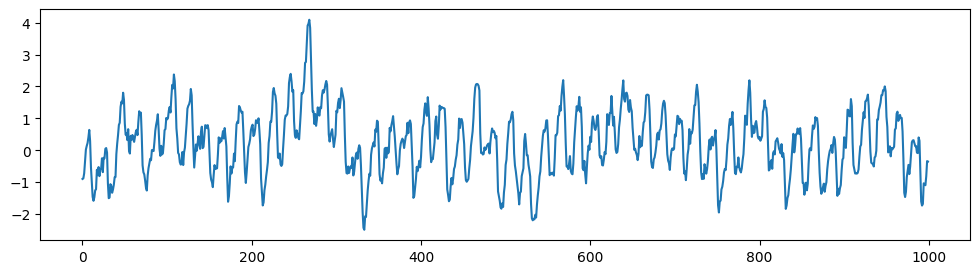

In [21]:
n_seconds = 5

tau = 0.015
fk = 1/(2*np.pi*tau)

fs = 1000
sig_pe_true = sim_oscillation(n_seconds, fs, 50, cycle='asine', rdsym=0.8)
sig_ap_true = sim_branching(n_seconds, fs, tau, 1000, mean=0, variance=1)

sig = sig_ap_true + sig_pe_true

sig = (sig-sig.mean())/sig.std()


# Plot
plt.figure(figsize=(12, 3))
plt.plot(sig[:1000]);

In [34]:
%%timeit
e1_inv = 1/(np.linalg.norm(sig[:-1])**2)
w = float(e1_inv * sig[:-1] @ sig[1:])

7.7 µs ± 10.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [52]:
e1_inv = 1/(np.linalg.norm(sig[:-1])**2)
w = float(e1_inv * sig[:-1] @ sig[1:])
print("AR(1) = ", w)

AR(1) =  0.9322802679803347


In [49]:
fs = 1000

fk_est = -(np.log(w) * fs) / (2 * np.pi)
tau_est = -(1/(np.log(w) * fs))
print("Estimated: ", 'tau=', tau_est, 'fk=', fk_est)
print("True     : ", 'tau=', tau, 'fk=', fk)

Estimated:  tau= 0.0142609017863635 fk= 11.160229940303061
True     :  tau= 0.015 fk= 10.61032953945969


fk_welch =  8.079521979072762


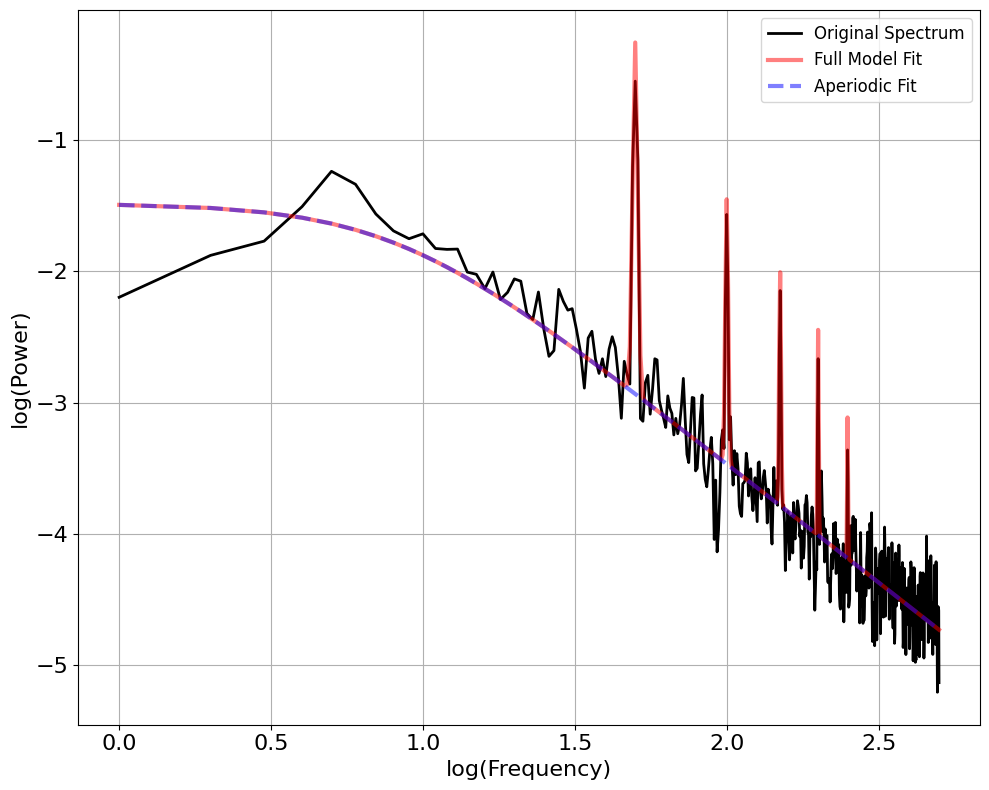

In [51]:
from fooof import FOOOF

freqs, powers = compute_spectrum(sig, fs)
freqs, powers = freqs[1:], powers[1:]

fm = FOOOF(aperiodic_mode='knee', max_n_peaks=5, verbose=False)
fm.fit(freqs, powers)
fm.plot(plt_log=True)

fk_welch = fm.aperiodic_params_[1]
print('fk_welch = ', fk_welch)